In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [2]:
#other useful imports 
import numpy as np
import scipy as sp
import scipy.stats as stats
import h5py

from utils import featurewise_norm


# CCA

## Generate and visualize example data

In [181]:
def look_at_data(toy_data, title=None, perm=None):
    #let's look at the data
    use_colors = []
    num_points = toy_data.shape[0]
    sta_color = np.asarray((1,0,0))
    end_color = np.asarray((0,1,0))
    for idx in xrange(num_points):
        use_colors.append((sta_color*idx + end_color*(num_points-idx))*1.0/num_points)
    if perm is not None:
        use_colors = np.asarray(use_colors)[perm]
    plt.scatter(toy_data[:, 0], toy_data[:, 1], c=use_colors)
    plt.axis('equal')
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.spines['left'].set_position('zero')
    ax.spines['bottom'].set_position('zero')
    if title is not None:
        ax.set_title(title)

In [64]:
#generate X
rng = np.random.RandomState(seed=0)
num_points = 200
data_mean = np.array([0, 0])
data_cov = 10*np.array([[0.5, 0.3], [0.3, 0.5]])
toy_data_x = rng.multivariate_normal(mean=data_mean,
                                   cov=data_cov, size=200)

x_data = np.arange(-2, 2, 4.0/num_points)
y_data = np.arange(2, -2, -4.0/num_points)
toy_data_x[:, 0] += x_data
toy_data_x[:, 1] += y_data

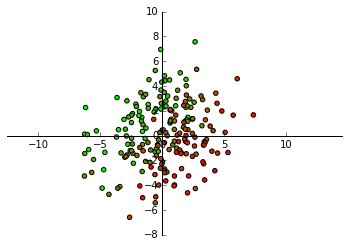

In [65]:
look_at_data(toy_data_x)

In [62]:
#generate Y
rng = np.random.RandomState(seed=1)
num_points = 200
data_mean = np.array([0, 0])
data_cov = 10*np.array([[0.5, -0.3], [-0.3, 0.5]])
toy_data_y = rng.multivariate_normal(mean=data_mean,
                                   cov=data_cov, size=200)

x_data = np.arange(-2, 2, 4.0/num_points)
y_data = np.arange(-2, 2, 4.0/num_points)
toy_data_y[:, 0] += x_data
toy_data_y[:, 1] += y_data

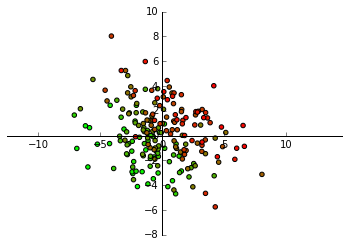

In [63]:
look_at_data(toy_data_y)

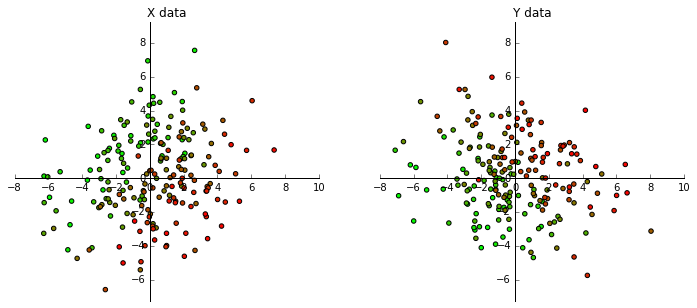

In [77]:
fig = plt.figure(figsize=(12,5))
plt.subplot(121)
look_at_data(toy_data_x, title='X data')
plt.subplot(122)
look_at_data(toy_data_y, title='Y data')

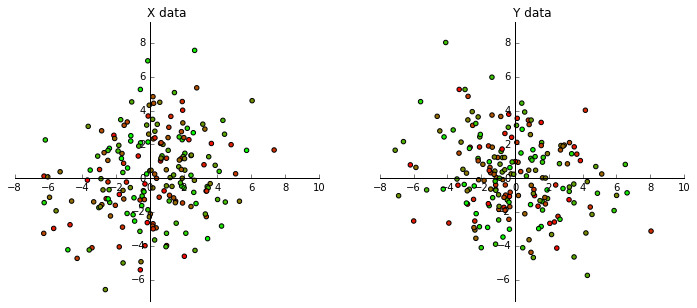

In [182]:
rng = np.random.RandomState(seed=2)
perm = rng.permutation(num_points)
fig = plt.figure(figsize=(12,5))
plt.subplot(121)
look_at_data(toy_data_x, title='X data', perm=perm)
plt.subplot(122)
look_at_data(toy_data_y, title='Y data', perm=perm)

## Do the CCA

In [66]:
from sklearn.cross_decomposition import CCA

In [67]:
cca = CCA(n_components=1)

In [68]:
cca.fit(toy_data_x, toy_data_y)

CCA(copy=True, max_iter=500, n_components=1, scale=True, tol=1e-06)

In [69]:
cca.x_weights_

array([[ 0.78793394],
       [-0.61575978]])

In [70]:
cca.y_weights_

array([[ 0.71298775],
       [ 0.70117649]])

In [111]:
trans_res = cca.transform(toy_data_x, toy_data_y)

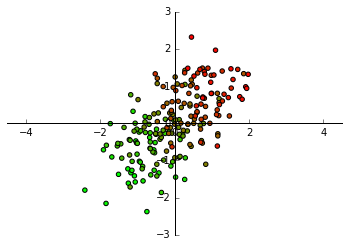

In [125]:
new_data = np.concatenate((trans_res[0], trans_res[1]), axis=1)
#print(new_data.shape)
look_at_data(new_data)

## Visualize the projection dimension on each data

In [94]:
def add_one_line(pt_x, pt_y, color=(0,0,1)):
    norm = 7
    plt.plot((pt_x*norm, -pt_x*norm), (pt_y*norm, -pt_y*norm), linewidth=3, color=color)

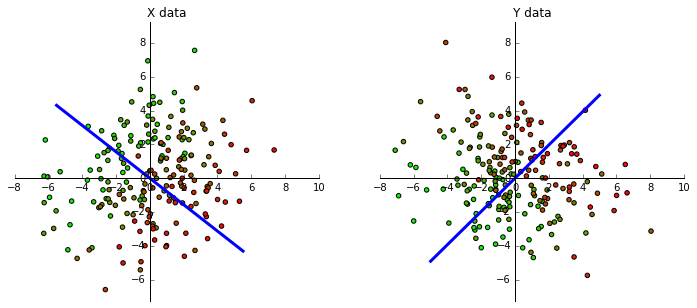

In [95]:
fig = plt.figure(figsize=(12,5))
plt.subplot(121)
look_at_data(toy_data_x, title='X data')
plt.hold(True)
add_one_line(*cca.x_weights_)
plt.subplot(122)
look_at_data(toy_data_y, title='Y data')
add_one_line(*cca.y_weights_)

In [97]:
from sklearn.decomposition import PCA

In [98]:
pca = PCA(n_components=1)

In [102]:
pca.fit(toy_data_x)
x_line = pca.components_

In [103]:
pca.fit(toy_data_y)
y_line = pca.components_

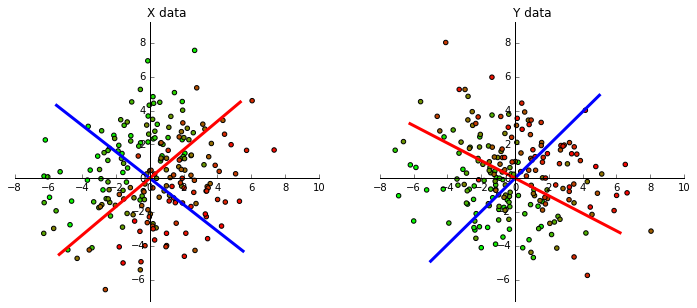

In [110]:
fig = plt.figure(figsize=(12,5))
plt.subplot(121)
look_at_data(toy_data_x, title='X data')
plt.hold(True)
add_one_line(*cca.x_weights_)
add_one_line(x_line[0][0], x_line[0][1], color=(1,0,0))
plt.subplot(122)
look_at_data(toy_data_y, title='Y data')
add_one_line(*cca.y_weights_)
add_one_line(y_line[0][0], y_line[0][1], color=(1,0,0))

## CCA on neural data

In [126]:
#ok let's load our usual data 
DATA_PATH = "/home/chengxuz/Class/psych253_2018/data/ventral_neural_data.hdf5"
Ventral_Dataset = h5py.File(DATA_PATH)

In [127]:
Neural_Data = Ventral_Dataset['time_averaged_trial_averaged'][:]
IT_NEURONS = Ventral_Dataset['neural_meta']['IT_NEURONS']
V4_NEURONS = Ventral_Dataset['neural_meta']['V4_NEURONS']
V4_Neural_Data = Neural_Data[:, V4_NEURONS]
IT_Neural_Data = Neural_Data[:, IT_NEURONS]

var_level = Ventral_Dataset['image_meta']['variation_level'][:]
categories = Ventral_Dataset['image_meta']['category'][:]   #array of category labels for all images  --> shape == (5760,)
unique_categories = np.unique(categories)                #array of unique category labels --> shape == (8,)
objects = Ventral_Dataset['image_meta']['object_name'][:]   #array of object labels for all images --> shape == (5670,)
unique_objects = np.unique(objects)                      #array of unique object labels --> shape == (64,) 

objects_by_category = {c: np.unique(objects[categories == c]) 
                       for c in unique_categories}


In [128]:
#use numpy recarray object to store metadata 
meta_array = np.core.records.fromarrays(Ventral_Dataset['image_meta'].values(),
                                        names=Ventral_Dataset['image_meta'].keys())

meta_array.dtype

dtype((numpy.record, [(u'category', 'S7'), (u'image_id', 'S40'), (u'object_name', 'S24'), (u'rotation_xy', '<f8'), (u'rotation_xz', '<f8'), (u'rotation_yz', '<f8'), (u'size', '<f8'), (u'translation_y', '<f8'), (u'translation_z', '<f8'), (u'variation_level', 'S2')]))

In [154]:
def plot_neural_cca(vl = 'V6', cat1 = 'Animals', cat2 = 'Faces', which_cmp=1):
    subset_inds1 = ((var_level == vl) & (categories == cat1)).nonzero()[0]
    subset_inds2 = ((var_level == vl) & (categories == cat2)).nonzero()[0]
    subset_inds = np.concatenate([subset_inds1, subset_inds2])
    IT_subset = IT_Neural_Data[subset_inds]
    V4_subset = V4_Neural_Data[subset_inds]  
    category_subset = categories[subset_inds]

    cls = CCA(n_components=which_cmp)
    cls.fit(V4_subset, IT_subset)

    Xproj = cls.transform(V4_subset, IT_subset)

    x = Xproj[0][:,which_cmp-1]
    y = Xproj[1][:,which_cmp-1]
    
    corr_val = np.corrcoef(x,y)[0,1]

    xb = x[category_subset == cat1]
    yb = y[category_subset == cat1]
    xc = x[category_subset == cat2]
    yc = y[category_subset == cat2]
    plt.scatter(xb, yb, color='b', label=cat1)
    plt.scatter(xc, yc, color='r', label=cat2)
    plt.axis('equal')
    plt.xlabel('V4 Data')
    plt.ylabel('IT Data')
    plt.legend()
    plt.title('Correlation value %f' % corr_val)

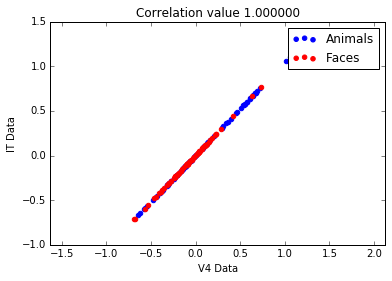

In [155]:
plot_neural_cca(vl='V0', which_cmp=1)

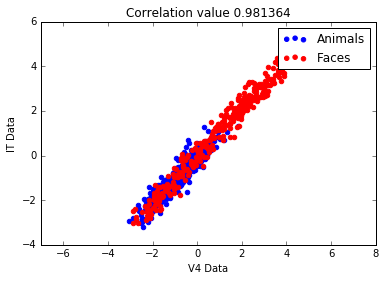

In [160]:
plot_neural_cca(vl='V3', which_cmp=1)

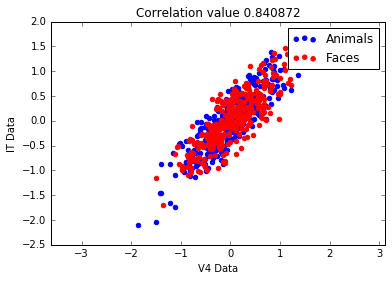

In [280]:
plot_neural_cca(vl='V3', which_cmp=10)

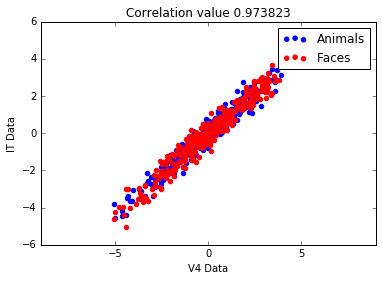

In [157]:
plot_neural_cca(vl='V6')

In [175]:
def plot_corr_neural_cca(vl = 'V6', num_cmp=1, label=''):
    subset_inds = (var_level == vl).nonzero()[0]
    IT_subset = IT_Neural_Data[subset_inds]
    V4_subset = V4_Neural_Data[subset_inds]  
    category_subset = categories[subset_inds]

    cls = CCA(n_components=num_cmp)
    cls.fit(V4_subset, IT_subset)

    Xproj = cls.transform(V4_subset, IT_subset)

    all_corr = []
    for which_idx in xrange(num_cmp):
        x = Xproj[0][:,which_idx]
        y = Xproj[1][:,which_idx]

        corr_val = np.corrcoef(x,y)[0,1]
        all_corr.append(corr_val)
    plt.plot(all_corr, label=label)

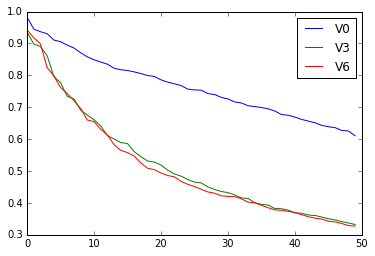

In [178]:
num_cmp=50
plot_corr_neural_cca(vl='V0', num_cmp=num_cmp, label='V0')
plt.hold(True)
plot_corr_neural_cca(vl='V3', num_cmp=num_cmp, label='V3')
plot_corr_neural_cca(vl='V6', num_cmp=num_cmp, label='V6')
plt.legend(loc='best')

# ICA

(array([  2.00000000e+00,   8.00000000e+00,   3.30000000e+01,
          7.60000000e+01,   2.39000000e+02,   5.16000000e+02,
          1.03000000e+03,   1.78700000e+03,   2.45800000e+03,
          3.01000000e+03,   3.21200000e+03,   2.76500000e+03,
          2.14000000e+03,   1.39700000e+03,   7.41000000e+02,
          3.67000000e+02,   1.49000000e+02,   4.90000000e+01,
          1.60000000e+01,   5.00000000e+00]),
 array([-3.75599003, -3.19489148, -2.63379294, -2.07269439, -1.51159585,
        -0.9504973 , -0.38939876,  0.17169979,  0.73279833,  1.29389688,
         1.85499542,  2.41609397,  2.97719251,  3.53829106,  4.09938961,
         4.66048815,  5.2215867 ,  5.78268524,  6.34378379,  6.90488233,
         7.46598088]),
 <a list of 20 Patch objects>)

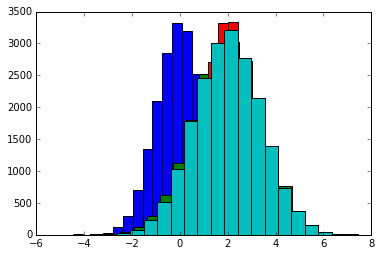

In [283]:
np.random.seed(0)

sample_num=20000

g1 = np.random.normal(size=sample_num)
#print(g1)
plt.hist(g1, bins=20)

#plt.figure()
g2 = np.random.normal(size=sample_num) + 2
#print(g2)

g3 = g1+g2
plt.hist(g3, bins=20)

plt.hist(g2, bins=20)

g1_ = np.random.normal(size=sample_num) + 1
g2_ = np.random.normal(size=sample_num) + 1

plt.hist(g1_+g2_, bins=20)


In [188]:
from scipy import signal
from sklearn.decomposition import FastICA

In [241]:
np.random.seed(0)
n_samples = 2000
time = np.linspace(0, 8, n_samples)

s1 = np.sin(2 * time)  # Signal 1 : sinusoidal signal
s2 = np.sign(np.sin(3 * time))  # Signal 2 : square signal
s3 = signal.sawtooth(2 * np.pi * time)  # Signal 3: saw tooth signal

imp = signal.unit_impulse(50, 'mid')
b, a = signal.butter(4, 0.2)
response = signal.lfilter(b, a, imp)
response = response[10:]
org_x_val = np.arange(0,1,1.0/40)
new_x_val = np.arange(0,1,1.0/200)
response = np.interp(new_x_val, org_x_val, response)
response = np.tile(response, [10])
response = response*5
response = response - np.mean(response)
s4 = response

S = np.c_[s1, s2, s3, s4]
S += 0.2 * np.random.normal(size=S.shape)  # Add noise

S /= S.std(axis=0)  # Standardize data
# Mix data
A = np.array([[1, 1, 1, 1], [0.5, 2, 1.0, 1.5], [1.5, 1.0, 2.0, 0.5], [2.0, 1.0, 0.5, 1.5]])  # Mixing matrix
X = np.dot(S, A.T)  # Generate observations

# Compute ICA
ica = FastICA(n_components=4)
S_ = ica.fit_transform(X)  # Reconstruct signals
A_ = ica.mixing_  # Get estimated mixing matrix

pca = PCA(n_components=4)
H = pca.fit_transform(X)

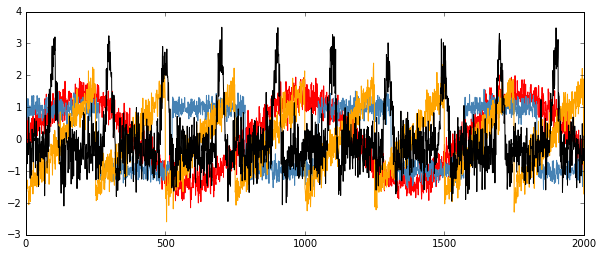

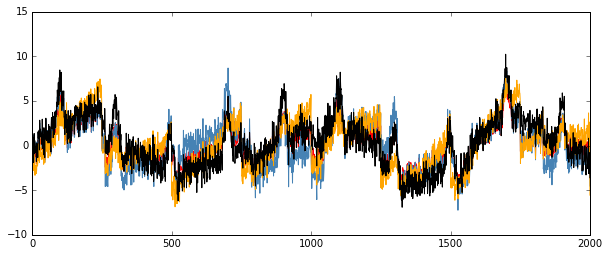

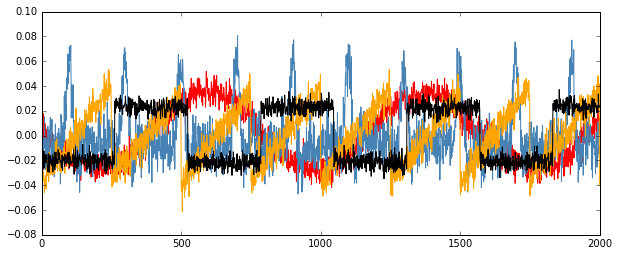

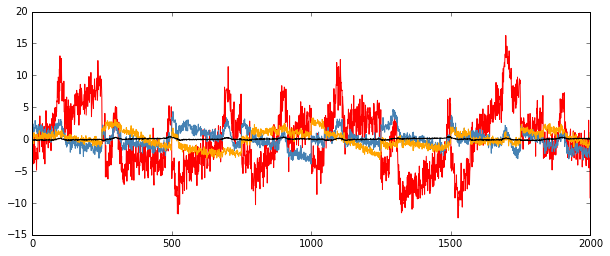

In [244]:
colors = ['red', 'steelblue', 'orange', 'black']
fig_size = (10, 4)
fig = plt.figure(figsize=fig_size)
for sig, color in zip(S.T, colors):
    plt.plot(sig, color=color)
    
fig = plt.figure(figsize=fig_size)
for sig, color in zip(X.T, colors):
    plt.plot(sig, color=color)
    
fig = plt.figure(figsize=fig_size)
for sig, color in zip(S_.T, colors):
    plt.plot(sig, color=color)
    
fig = plt.figure(figsize=fig_size)
for sig, color in zip(H.T, colors):
    plt.plot(sig, color=color)

In [245]:
def plot_neural_ica(vl = 'V6', cat1 = 'Animals', cat2 = 'Faces', which_cmp=2, whiten=True):
    subset_inds1 = ((var_level == vl) & (categories == cat1)).nonzero()[0]
    subset_inds2 = ((var_level == vl) & (categories == cat2)).nonzero()[0]
    subset_inds = np.concatenate([subset_inds1, subset_inds2])
    IT_subset = IT_Neural_Data[subset_inds]
    category_subset = categories[subset_inds]

    cls = FastICA(n_components=which_cmp, whiten=whiten)
    cls.fit(IT_subset)

    Xproj = cls.transform(IT_subset)

    x = Xproj[:,0]
    y = Xproj[:,1]

    xb = x[category_subset == cat1]
    yb = y[category_subset == cat1]
    xc = x[category_subset == cat2]
    yc = y[category_subset == cat2]
    plt.scatter(xb, yb, color='b', label=cat1)
    plt.scatter(xc, yc, color='r', label=cat2)
    plt.axis('equal')
    plt.xlabel('Source 1')
    plt.ylabel('Source 2')
    plt.legend()

In [275]:
def plot_neural_pca(vl = 'V6', cat1 = 'Animals', cat2 = 'Faces', which_cmp=2):
    subset_inds1 = ((var_level == vl) & (categories == cat1)).nonzero()[0]
    subset_inds2 = ((var_level == vl) & (categories == cat2)).nonzero()[0]
    subset_inds = np.concatenate([subset_inds1, subset_inds2])
    IT_subset = IT_Neural_Data[subset_inds]
    category_subset = categories[subset_inds]

    cls = PCA(n_components=which_cmp)
    cls.fit(IT_subset)

    Xproj = cls.transform(IT_subset)

    x = Xproj[:,0]
    y = Xproj[:,1]

    xb = x[category_subset == cat1]
    yb = y[category_subset == cat1]
    xc = x[category_subset == cat2]
    yc = y[category_subset == cat2]
    plt.scatter(xb, yb, color='b', label=cat1)
    plt.scatter(xc, yc, color='r', label=cat2)
    plt.axis('equal')
    plt.xlabel('PC 1')
    plt.ylabel('PC 2')
    plt.legend()

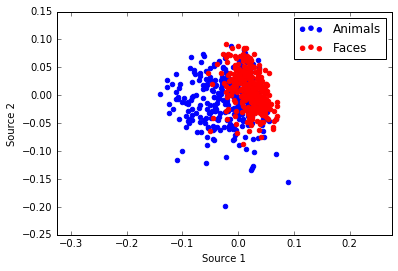

In [239]:
plot_neural_ica(vl = 'V6')

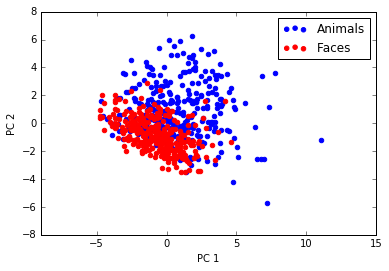

In [279]:
plot_neural_pca(vl = 'V6')

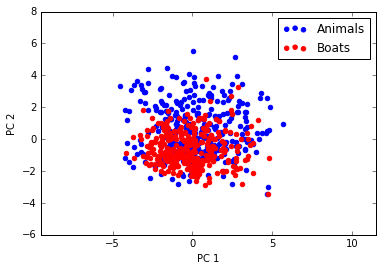

In [277]:
plot_neural_pca(vl='V3', cat1 = 'Animals', cat2 = 'Boats')

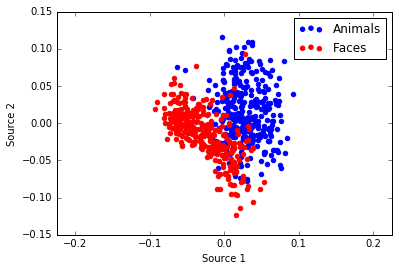

In [270]:
plot_neural_ica(vl = 'V3')

/usr/local/lib/python2.7/dist-packages/sklearn/decomposition/fastica_.py:295: UserWarning: Ignoring n_components with whiten=False.
  warnings.warn('Ignoring n_components with whiten=False.')
/usr/local/lib/python2.7/dist-packages/sklearn/decomposition/fastica_.py:118: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


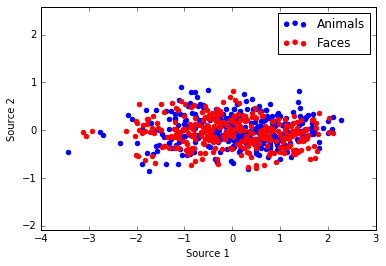

In [246]:
# You need to whiten the data

plot_neural_ica(vl = 'V6', whiten=False)

# MDS

In [263]:
from sklearn.manifold import MDS

In [267]:
def plot_neural_mds(vl = 'V6', cat1 = 'Animals', cat2 = 'Faces', which_cmp=2):
    subset_inds1 = ((var_level == vl) & (categories == cat1)).nonzero()[0]
    subset_inds2 = ((var_level == vl) & (categories == cat2)).nonzero()[0]
    subset_inds = np.concatenate([subset_inds1, subset_inds2])
    IT_subset = IT_Neural_Data[subset_inds]
    category_subset = categories[subset_inds]

    cls = MDS(n_components=which_cmp)
    Xproj = cls.fit_transform(IT_subset)

    x = Xproj[:,0]
    y = Xproj[:,1]

    xb = x[category_subset == cat1]
    yb = y[category_subset == cat1]
    xc = x[category_subset == cat2]
    yc = y[category_subset == cat2]
    plt.scatter(xb, yb, color='b', label=cat1)
    plt.scatter(xc, yc, color='r', label=cat2)
    plt.axis('equal')
    plt.xlabel('Source 1')
    plt.ylabel('Source 2')
    plt.legend()

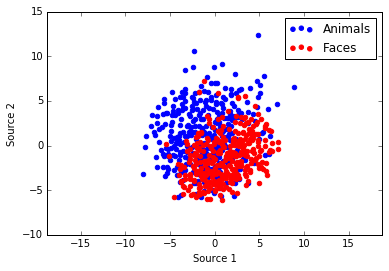

In [268]:
plot_neural_mds()

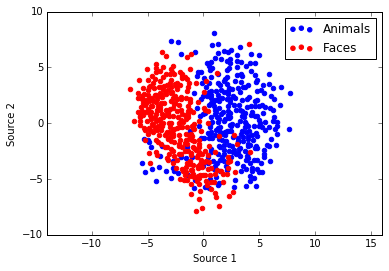

In [269]:
plot_neural_mds(vl='V3')

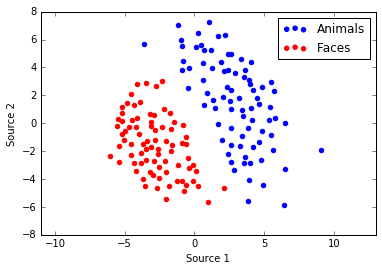

In [271]:
plot_neural_mds(vl='V0')